#### Importing the dependencies

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM
The app needs to connect to the sqlite data and SQLAlchemy will help with this process

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create the connection to the database thru engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found or tables (this tell us what tables are 
# are in our data base given by sqlite)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Data Analysis
It is important to analyse the data so we can understand the queries that need to be executed

In [10]:
# we are going to inspect the columns of both of the tables givne to identify possible Queries
inspector = inspect(engine)
station_col =inspector.get_columns('Station')
print('Station table\n')
for c in station_col:
    print(c['name'], c["type"])
print('\nMeasurments table\n')
measurment_col = inspector.get_columns('Measurement')
for c in measurment_col:
    print(c['name'], c["type"])

Station table

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

Measurments table

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


### Query to retrieve the last 12 months of precipitation data

In [9]:
# check for the length of the measurments table
session.query(func.count(Measurement.date)).all()

[(19550)]

In [10]:
# also we are going to find the earliest date finding the order_by
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

('2017-08-23',)


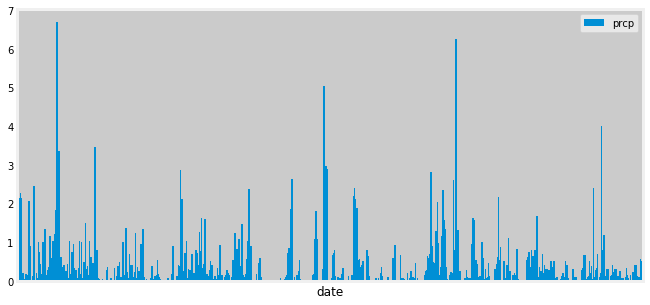

In [20]:
session.query(Measurement.date, Measurement.prcp).filter().all()

# we use this command to find the last date of our dataset
print(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
last_12months = dt.date(2017,8,23) - dt.timedelta(days=365)
last_12months

# the query will use all the data point from the date we created to the end of the dataset
session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12months).order_by(Measurement.date).all()

# we create a data frame that is going to store the data
precipitation_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12months).order_by(Measurement.date).all())
# we set the the column date as the index
precipitation_df = precipitation_df.set_index('date')

# we drop na values
precipitation_df = precipitation_df.dropna()
precipitation_df

# plot the data in a barchart

precipitation_df.plot.bar(width=5, figsize=(10,5))

plot_precip = plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.show()
plt.savefig('Precipitations.png')

In [12]:
# we described the data obtained by the query
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# The following query shows how many stations are available in this dataset

session.query(Station.station).count()

9

We are going to create different variables as sel to retrieve different values from the dataset

In [14]:

# sel = [Station.stock, 
#        func.avg(Dow.open_price), 
#        func.avg(Dow.high_price), 
#        func.avg(Dow.low_price), 
#        func.avg(Dow.close_price)]

sel = [Station.id,
       Station.station, 
       Station.name, 
      Station.latitude,
      Station.longitude,
      Station.elevation]
sel2 = [Measurement.station,
       func.count(Measurement.station)]

# id INTEGER
# station TEXT
# name TEXT
# latitude FLOAT
# longitude FLOAT
# elevation FLOAT
session.query(*sel2).all()
# session.query()

[('USC00519397', 19550)]

In [16]:
# The following query answers to the questions
# What are the most active stations? (i.e. what stations have the most rows)?
# It showcase the stations in descending order
session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, we calculated the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

session.query(Measurement.station,func.max(Measurement.tobs),
             func.min(Measurement.tobs),
             func.avg(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel3 = [Measurement.id,Measurement.station,Measurement.date, 
        Measurement.prcp, Measurement.tobs]

session.query(*sel3).\
        filter(Measurement.station == "USC00519281").\
        filter(Measurement.date >= last_12months).all()

[(14608, 'USC00519281', '2016-08-23', 1.79, 77.0),
 (14609, 'USC00519281', '2016-08-24', 2.15, 77.0),
 (14610, 'USC00519281', '2016-08-25', 0.06, 80.0),
 (14611, 'USC00519281', '2016-08-26', 0.01, 80.0),
 (14612, 'USC00519281', '2016-08-27', 0.12, 75.0),
 (14613, 'USC00519281', '2016-08-28', 0.6, 73.0),
 (14614, 'USC00519281', '2016-08-29', 0.35, 78.0),
 (14615, 'USC00519281', '2016-08-30', 0.0, 77.0),
 (14616, 'USC00519281', '2016-08-31', 0.24, 78.0),
 (14617, 'USC00519281', '2016-09-01', 0.02, 80.0),
 (14618, 'USC00519281', '2016-09-02', 0.01, 80.0),
 (14619, 'USC00519281', '2016-09-03', 0.12, 78.0),
 (14620, 'USC00519281', '2016-09-04', 0.14, 78.0),
 (14621, 'USC00519281', '2016-09-05', 0.03, 78.0),
 (14622, 'USC00519281', '2016-09-06', 0.11, 73.0),
 (14623, 'USC00519281', '2016-09-07', 0.16, 74.0),
 (14624, 'USC00519281', '2016-09-08', 0.07, 80.0),
 (14625, 'USC00519281', '2016-09-09', 0.16, 79.0),
 (14626, 'USC00519281', '2016-09-10', 0.09, 77.0),
 (14627, 'USC00519281', '2016-09-

In [23]:
# pass the query results to a df to create a histogram plot 
most_active_df = pd.DataFrame(session.query(*sel3).\
        filter(Measurement.station == "USC00519281").\
        filter(Measurement.date >= last_12months).all())
most_active_df

,id,station,date,prcp,tobs
0,14608,USC00519281,2016-08-23,1.79,77.0
1,14609,USC00519281,2016-08-24,2.15,77.0
2,14610,USC00519281,2016-08-25,0.06,80.0
3,14611,USC00519281,2016-08-26,0.01,80.0
4,14612,USC00519281,2016-08-27,0.12,75.0
5,14613,USC00519281,2016-08-28,0.60,73.0
6,14614,USC00519281,2016-08-29,0.35,78.0
7,14615,USC00519281,2016-08-30,0.00,77.0
8,14616,USC00519281,2016-08-31,0.24,78.0
9,14617,USC00519281,2016-09-01,0.02,80.0


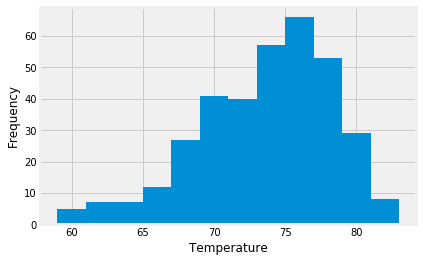

In [24]:
# create the histogram plot with the information received and separated in bins based in temperature 
hist_plot = plt.hist(most_active_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.savefig('Temperature_frequency.png')

In [25]:
# we are getting the start date read it in tuples 
start = '2016-11-29'
year, month, day = start.split('-')
start_date = dt.date(int(year), int(month), int(day))

In [26]:
# A query to get the temperature MIN, MAX, AVG and the station by date 
results_dates = session.query(Measurement.date,Measurement.station, func.avg(Measurement.tobs),func.min(Measurement.tobs),func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).group_by(Measurement.date).\
    order_by(Measurement.date).all()


dates_list=[]
for date, station, avg, min1, max1 in results_dates:
    dates_dict={}
    dates_dict['date'] = date
    dates_dict['station'] = station
    dates_dict['TAVG'] = avg
    dates_dict['TMIN'] = min1
    dates_dict['TMAX'] = max1
    dates_list.append(dates_dict)
dates_list

[{'date': '2016-11-29',
  'station': 'USC00519523',
  'TAVG': 72.42857142857143,
  'TMIN': 67.0,
  'TMAX': 76.0},
 {'date': '2016-11-30',
  'station': 'USC00514830',
  'TAVG': 74.42857142857143,
  'TMIN': 72.0,
  'TMAX': 76.0},
 {'date': '2016-12-01',
  'station': 'USC00519523',
  'TAVG': 73.71428571428571,
  'TMIN': 71.0,
  'TMAX': 76.0},
 {'date': '2016-12-02',
  'station': 'USC00514830',
  'TAVG': 72.28571428571429,
  'TMIN': 70.0,
  'TMAX': 77.0},
 {'date': '2016-12-03',
  'station': 'USC00514830',
  'TAVG': 71.5,
  'TMIN': 67.0,
  'TMAX': 75.0},
 {'date': '2016-12-04',
  'station': 'USC00514830',
  'TAVG': 73.0,
  'TMIN': 69.0,
  'TMAX': 77.0},
 {'date': '2016-12-05',
  'station': 'USC00514830',
  'TAVG': 69.14285714285714,
  'TMIN': 67.0,
  'TMAX': 76.0},
 {'date': '2016-12-06',
  'station': 'USC00517948',
  'TAVG': 69.16666666666667,
  'TMIN': 67.0,
  'TMAX': 74.0},
 {'date': '2016-12-07',
  'station': 'USC00514830',
  'TAVG': 71.14285714285714,
  'TMIN': 68.0,
  'TMAX': 76.0},


In [27]:
for one_date in results_dates:
    print(one_date)
#     information_ = session.query(Measurement.date, Measurement.station,func.avg(Measurement.tobs),func.min(Measurement.tobs),func.max(Measurement.tobs)).\
#         filter(Measurement.date == one_date).all()

('2016-11-29', 'USC00519523', 72.42857142857143, 67.0, 76.0)
('2016-11-30', 'USC00514830', 74.42857142857143, 72.0, 76.0)
('2016-12-01', 'USC00519523', 73.71428571428571, 71.0, 76.0)
('2016-12-02', 'USC00514830', 72.28571428571429, 70.0, 77.0)
('2016-12-03', 'USC00514830', 71.5, 67.0, 75.0)
('2016-12-04', 'USC00514830', 73.0, 69.0, 77.0)
('2016-12-05', 'USC00514830', 69.14285714285714, 67.0, 76.0)
('2016-12-06', 'USC00517948', 69.16666666666667, 67.0, 74.0)
('2016-12-07', 'USC00514830', 71.14285714285714, 68.0, 76.0)
('2016-12-08', 'USC00514830', 72.0, 70.0, 75.0)
('2016-12-09', 'USC00514830', 69.66666666666667, 68.0, 72.0)
('2016-12-10', 'USC00514830', 71.0, 68.0, 76.0)
('2016-12-11', 'USC00519523', 71.6, 69.0, 78.0)
('2016-12-12', 'USC00514830', 68.14285714285714, 65.0, 75.0)
('2016-12-13', 'USC00514830', 68.42857142857143, 65.0, 72.0)
('2016-12-14', 'USC00514830', 69.71428571428571, 68.0, 72.0)
('2016-12-15', 'USC00514830', 68.42857142857143, 62.0, 75.0)
('2016-12-16', 'USC00519281'